<h1> <strong> Tarefa 3: Entendendo convoluções </strong> </h1>
<p> Antonio Pilan. NUSP: 10562611 </p>

<h3>Ferramentas: OpenCV, Matplotlib e Numpy</h3>

<p>
Nessa tarefa, vamos explorar o conceito de convoluções e aplicá-lo em uma imagem gerada no OpenCV
</p>

In [31]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

<h3>Criando a imagem</h3>

<p>
    Vamos usar uma imagem 512x512 para executar as tarefas de convolução, composta por quatro quadrados de mesmo tamanho, dois em cima e dois em baixo (2 x 2). Os dois quadrados que formam a diagonal principal são pretos e os outros dois são brancos
</p>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


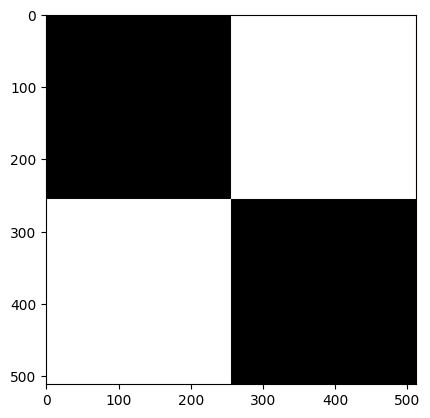

In [32]:
height, width = 512, 512
b, g, r = 0xFFFFFF, 0xFFFFFF, 0xFFFFFF 
image = np.zeros((height, width, 3))
image[:256, 256:,0], image[256:, :256,0] = r, r
image[:256, 256:,1], image[256:, :256,1] = g, g
image[:256, 256:,2], image[256:, :256,2] = b, b

plt.imshow(image)

Agora, vamos um criar um Kernel no formato de $n \times n$ dimensões, onde vamos definir um filtro passa baixa de média

In [33]:
def kernel_media(n):
    kernel=[]
    n=n #DEFININDO A DIMENSÃO DO KERNEL
    for i in range(n):
        row=[] 
        for j in range(n): 
            row.append(1) 
        kernel.append(row) 
    kernel = np.array(kernel)
    #print(kernel)

    kernel = kernel / n**2 #NORMALIZAÇÃO DO KERNEL
    kernel = cv.flip(kernel, 0) 
    return kernel

Uma observação: a ferramenta do OpenCV filter2D realiza uma correlação na imagem, portanto, flipamos o Kernel para termos uma CONVOLUÇÃO

Se aplicarmos na imagem que geramos, temos:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


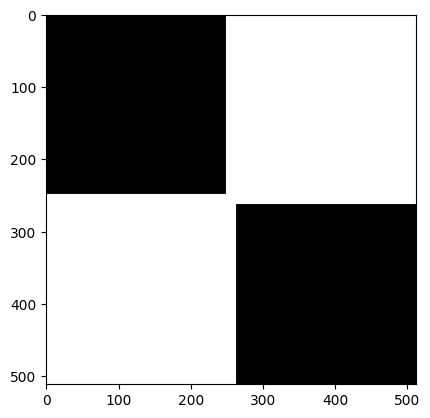

In [34]:
kernel = kernel_media(n=15)
flt_img = cv.filter2D(src=image, ddepth=-1, kernel=kernel) 

plt.imshow(flt_img)

O que, a princípio, me parece um comportamento estranho. Particularmente, esperava um certo "borrão" nas bordas dos quadrados, então fui fazer o teste usando o mesmo Kernel na imagem utilizada em exercícios anteriores e o comportamento da imagem ao convoluir com o Kernel foi o esperado:

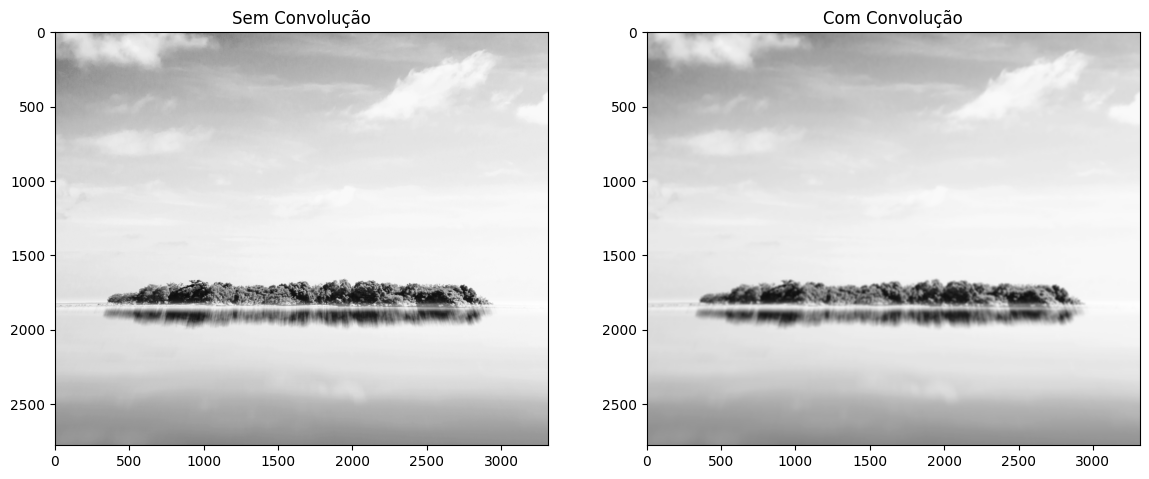

In [35]:
img = cv.imread('img_tarefa1.jpg') 
flt_img2 = cv.filter2D(img,-1,kernel) 

fig = plt.figure(figsize=(14, 14))

ax1 = fig.add_subplot(2,2,1)
ax1.title.set_text('Sem Convolução')
ax1.imshow(img)

ax2 = fig.add_subplot(2,2,2)
ax2.title.set_text('Com Convolução')
ax2.imshow(flt_img2)


Estudando o mesmo comportamento para diferente valores de $n$, também temos o esperado:

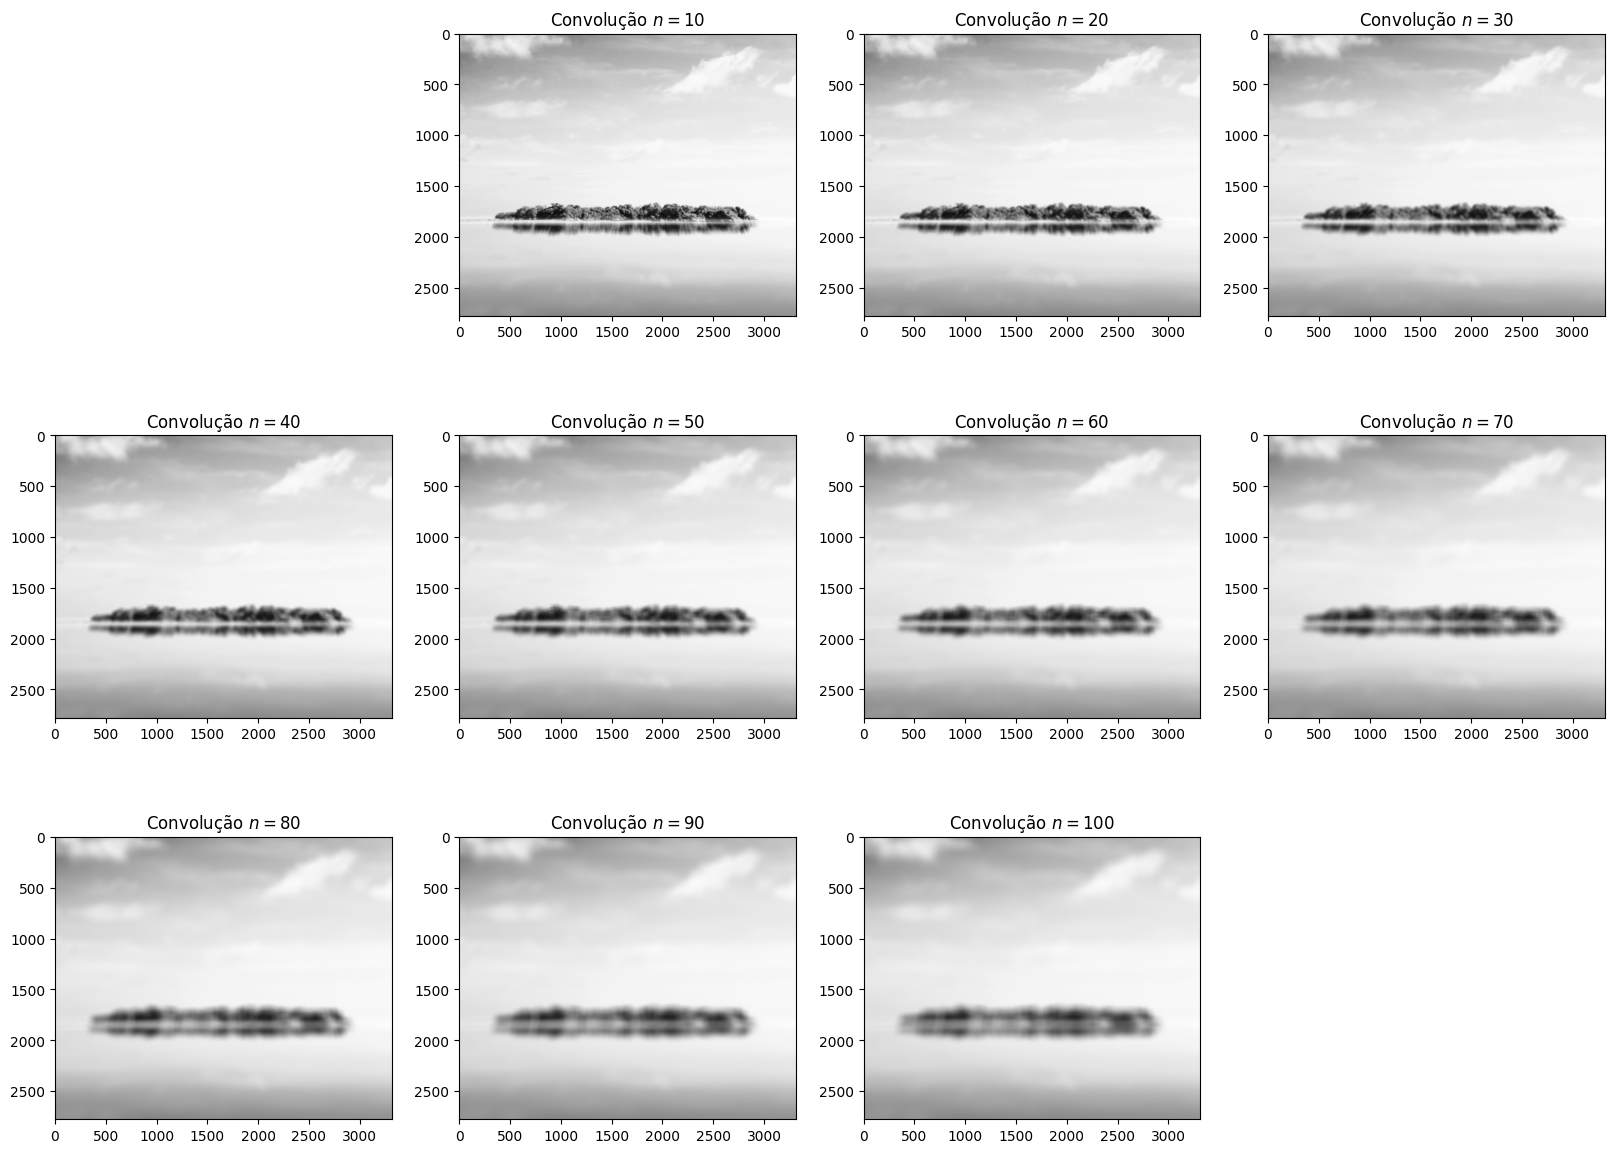

In [36]:
img = cv.imread('img_tarefa1.jpg') 

fig = plt.figure(figsize=(20, 20))
i=1

for i in range (1,11):
    ax = fig.add_subplot(4, 4, i+1)
    ax.title.set_text(f'Convolução $n={i*10}$')
    kernel = kernel_media(n=i*10) #VALOR DE N AUMENTANDO SEGUINDO LAÇO FOR
    flt_img3 = cv.filter2D(img,-1,kernel)
    
    ax.imshow(flt_img3)

O que mantém o comportamento esperado: Quanto maior o Kernel, mais pixeis entram na contagem da média e, portanto, maior o "blur" da imagem

Portanto, o Filto Passa Baixa está sendo aplicado de maneira correta. Com essa certeza podemos, agora, estudar o comportamento das bordas de uma imagem usando as funções de PADDING no OpenCV

Novamente ressaltando a ferramenta de convolução filtar2D do OpenCV: Ela parte do princípio de uma imagem sem nenhum padding... Portanto, ela ignora os pixeis da borda até que o Kernel se encaixe perfeitamente na imagem... O próprio OpenCV tem uma ferramenta para inserirmos o padding de maneira manual:

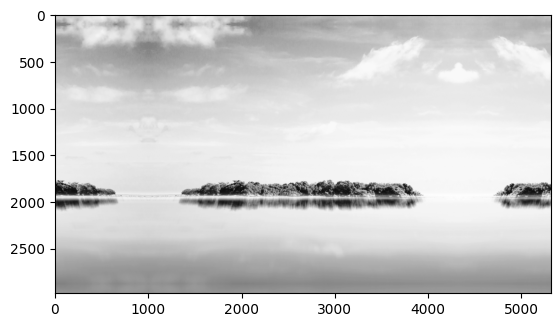

In [37]:
#ESPELHAMENTO
img = cv.imread('img_tarefa1.jpg')
img = cv.copyMakeBorder(img, 100, 100, 1000, 1000, cv.BORDER_REFLECT)
plt.imshow(img)

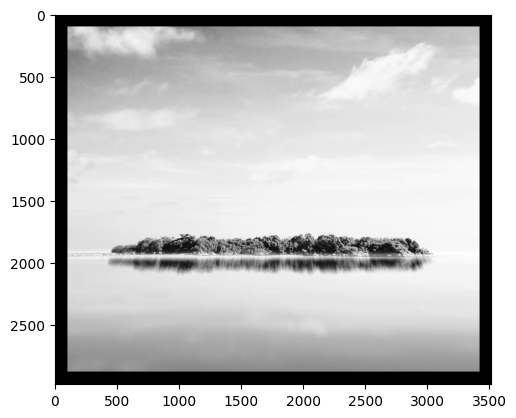

In [38]:
#CONSTANTE
img = cv.imread('img_tarefa1.jpg')
img = cv.imread('img_tarefa1.jpg')
img = cv.copyMakeBorder(img, 100, 100, 100, 100, cv.BORDER_CONSTANT, None, value = 0) 
plt.imshow(img)

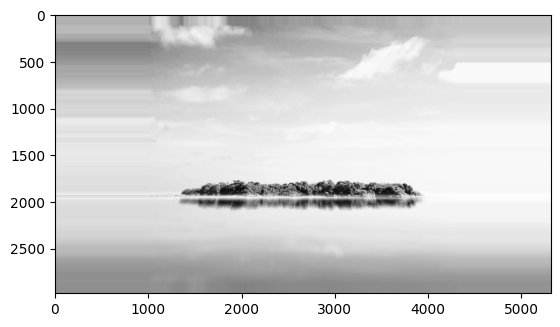

In [39]:
#REPLICAÇÃO
img = cv.imread('img_tarefa1.jpg')
img = cv.copyMakeBorder(img, 100, 100, 1000, 1000, cv.BORDER_REPLICATE)
plt.imshow(img)

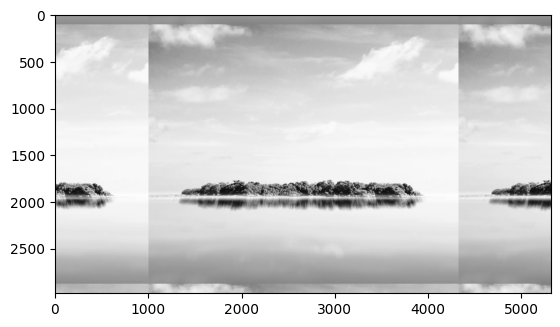

In [40]:
#PERIÓDICA
img = cv.imread('img_tarefa1.jpg')
img = cv.copyMakeBorder(img, 100, 100, 1000, 1000, cv.BORDER_WRAP)
plt.imshow(img)

Nesse caso, é mais conveniente usarmos uma ferramenta da biblioteca SciPy, com a ferramenta convolve2D que têm inbuilt as funções de padding:

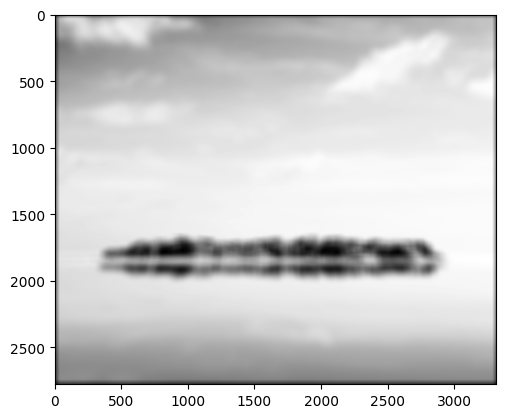

In [55]:
#PADDING CONSTANTE COM FILL VALUE = 0 

from scipy.signal import convolve2d
img = cv.imread('img_tarefa1.jpg', 0)
kernel = kernel_media(n=70)

img_fill = convolve2d(img,kernel, mode='same', boundary="fill", fillvalue=0)

plt.imshow(img_fill, cmap="gray")

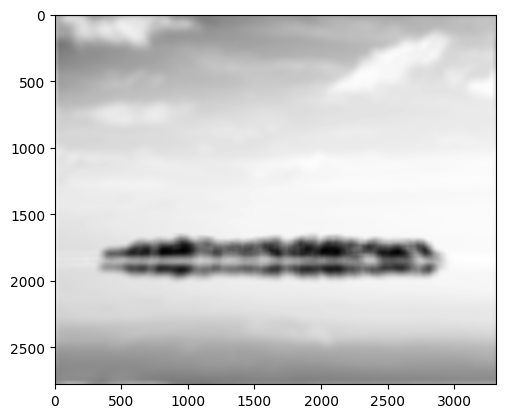

In [42]:
#PADDING REPLICANTE

img = cv.imread('img_tarefa1.jpg', 0)
kernel = kernel_media(n=70)

img_fill = convolve2d(img,kernel, mode='same', boundary="wrap")

plt.imshow(img_fill, cmap="gray")

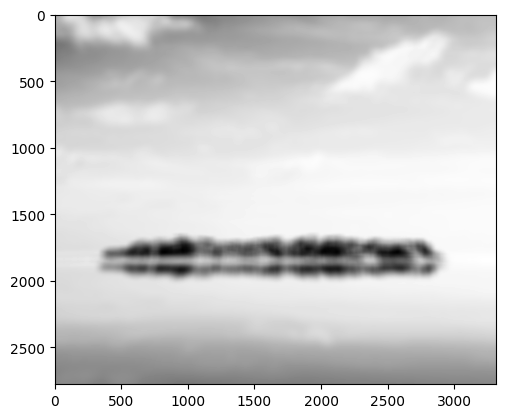

In [43]:
#PADDING SIMÉTRICO

img = cv.imread('img_tarefa1.jpg', 0)
kernel = kernel_media(n=70)

img_fill = convolve2d(img,kernel, mode='same', boundary="symm")

plt.imshow(img_fill, cmap="gray")

Na imagem específica, kerneis que tendem a usar condições de borda mantendo o padrão da imagem tendem a ter um resultado melhor

Vamos, agora, definir um Kernel Gaussiano usando a expressão 
\begin{equation}
    K(x,y)= \frac{1}{2\pi\sigma^2} e^{\frac{{|x-y|}^2}{2\sigma^2}}
\end{equation}

E estudar o seu comportamento, vamos criar na função aonde iremos entregar o tamanho do kernel e o valor de $\sigma$ para definirmos o kernel

In [44]:
def gaussian_kernel(kernel_size, sigma):
    kernel = np.fromfunction(lambda x, y: (1 / (2 * np.pi * sigma**2)) * np.exp(-((x - kernel_size//2)**2 + (y - kernel_size//2)**2) / (2 * sigma**2)), (kernel_size, kernel_size))
    normal = kernel / np.sum(kernel)
    return normal

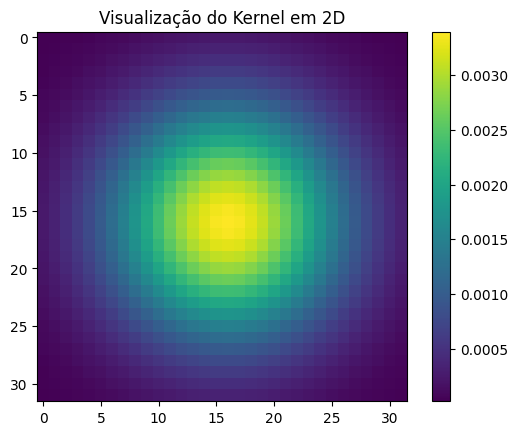

In [45]:
kernel_gauss = gaussian_kernel(kernel_size=32, sigma=7) #CHAMANDO FUNÇÃO DE CRIAÇÃO DO KERNEL GAUSSIANO

plt.imshow(kernel_gauss, cmap='viridis')
plt.title('Visualização do Kernel em 2D')
plt.colorbar()
plt.show()

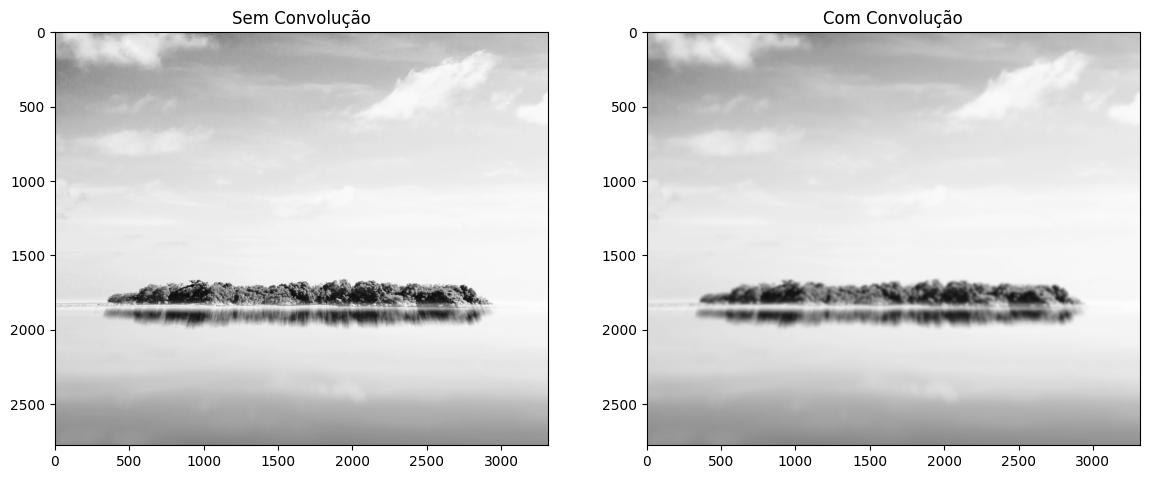

In [46]:
img = cv.imread('img_tarefa1.jpg') 
flt_img4 = cv.filter2D(img,-1,kernel_gauss) 

fig = plt.figure(figsize=(14, 14))

ax1 = fig.add_subplot(2,2,1)
ax1.title.set_text('Sem Convolução')
ax1.imshow(img)

ax2 = fig.add_subplot(2,2,2)
ax2.title.set_text('Com Convolução')
ax2.imshow(flt_img4)

Agora, vamos entender o comportamento das variáveis tamanho do kernel e $\sigma$

<>:8: SyntaxWarning: invalid escape sequence '\s'
<>:8: SyntaxWarning: invalid escape sequence '\s'
C:\Users\anton\AppData\Local\Temp\ipykernel_19124\1890029947.py:8: SyntaxWarning: invalid escape sequence '\s'
  ax.title.set_text(f'Convolução $n={i*10}$ e $\sigma={sigma}$')


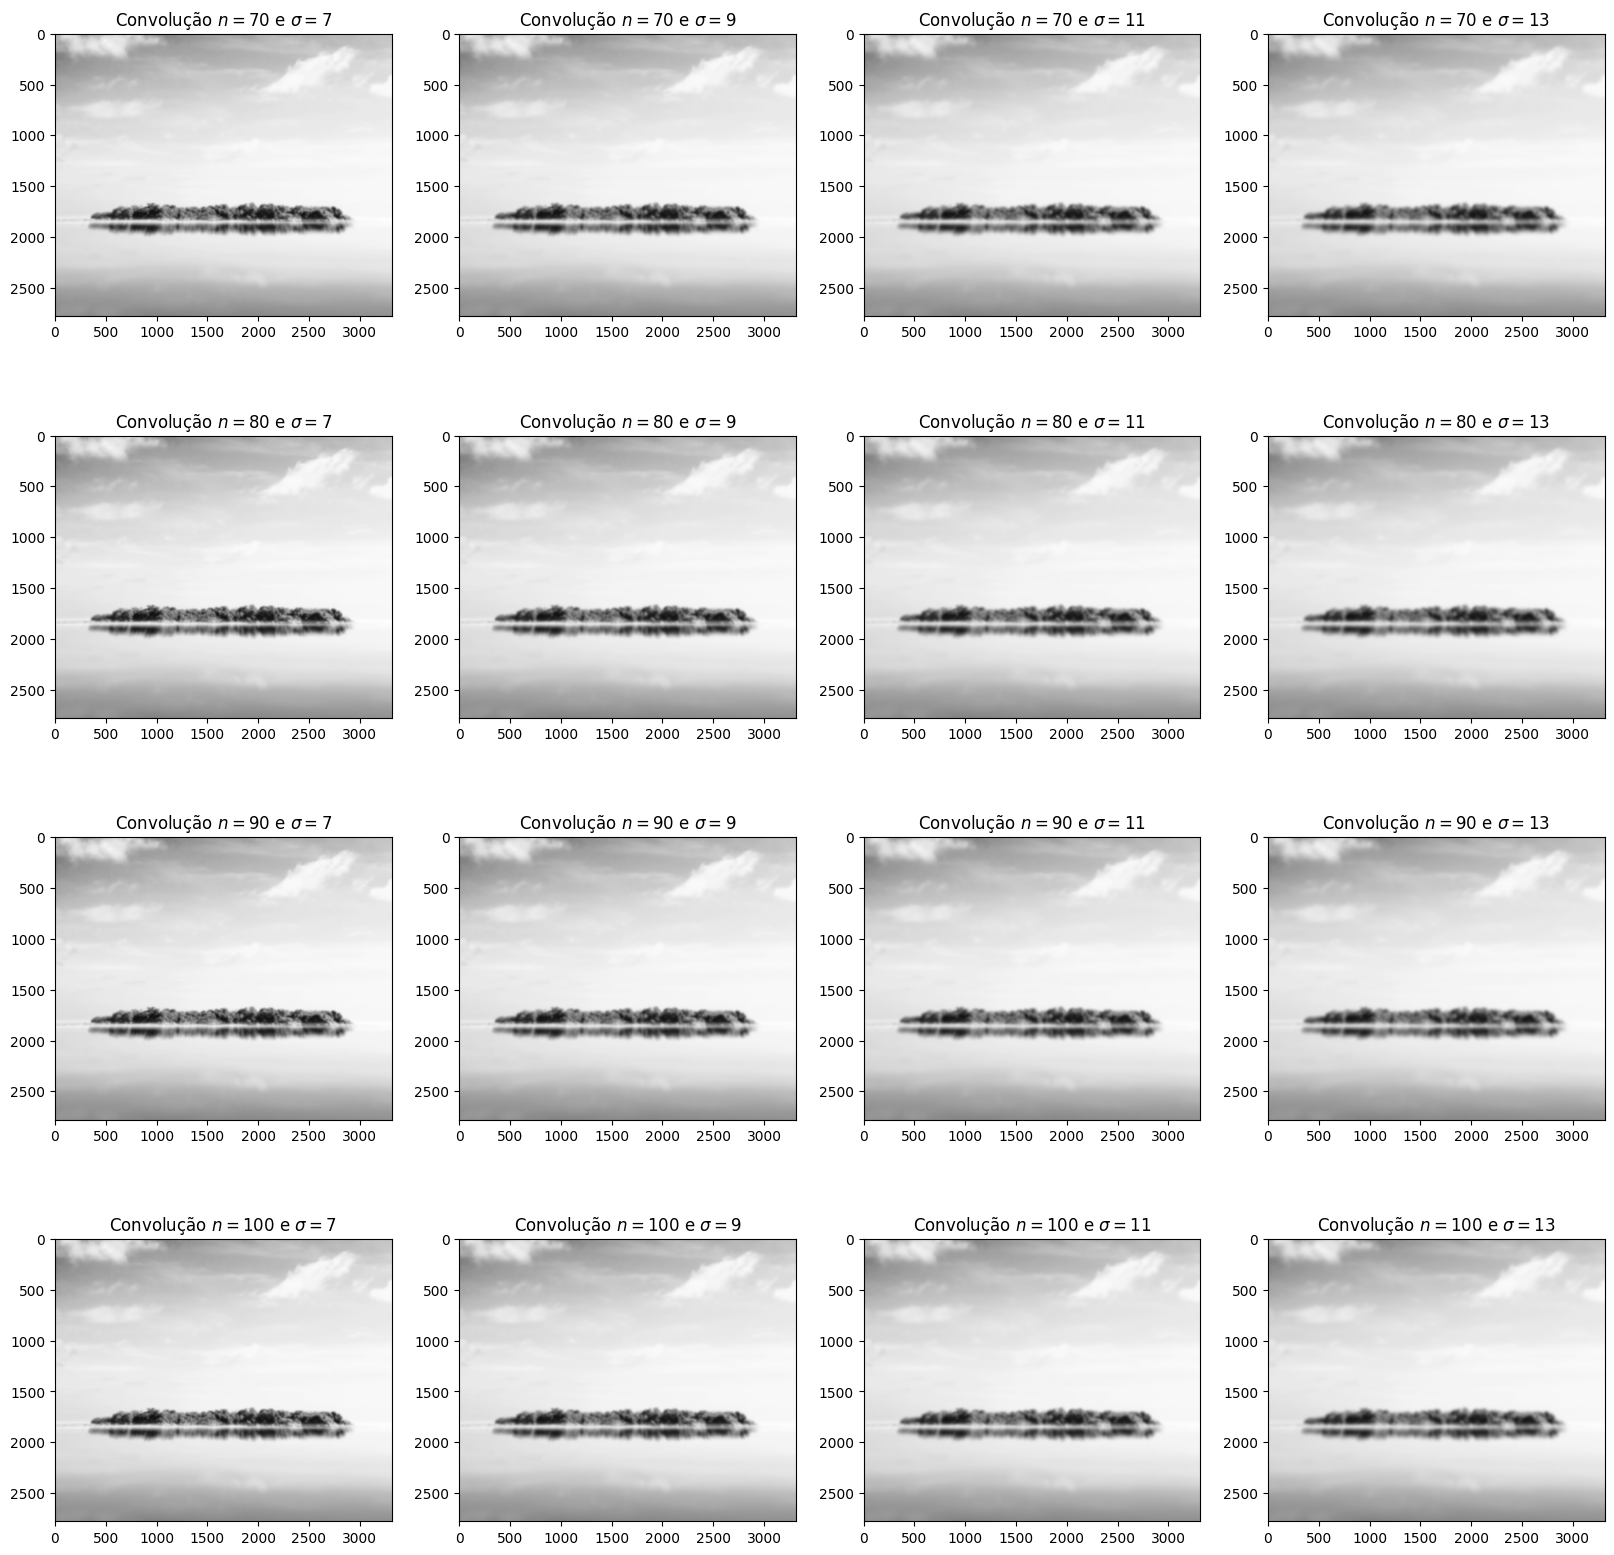

In [47]:
fig = plt.figure(figsize=(20, 20))
i=1
plot=1
for i in range (7,11):
    for sigma in range(7,14,2):
        ax = fig.add_subplot(4, 4, plot)
        plot += 1
        ax.title.set_text(f'Convolução $n={i*10}$ e $\sigma={sigma}$')
        kernel = gaussian_kernel(kernel_size=i*10, sigma = sigma) 
        flt_img3 = cv.filter2D(img,-1,kernel)
        ax.imshow(flt_img3)

Cada Kernel teve a seguinte distribuição?

<>:8: SyntaxWarning: invalid escape sequence '\s'
<>:8: SyntaxWarning: invalid escape sequence '\s'
C:\Users\anton\AppData\Local\Temp\ipykernel_19124\3161124282.py:8: SyntaxWarning: invalid escape sequence '\s'
  ax.title.set_text(f'Convolução $n={i*10}$ e $\sigma={sigma}$')


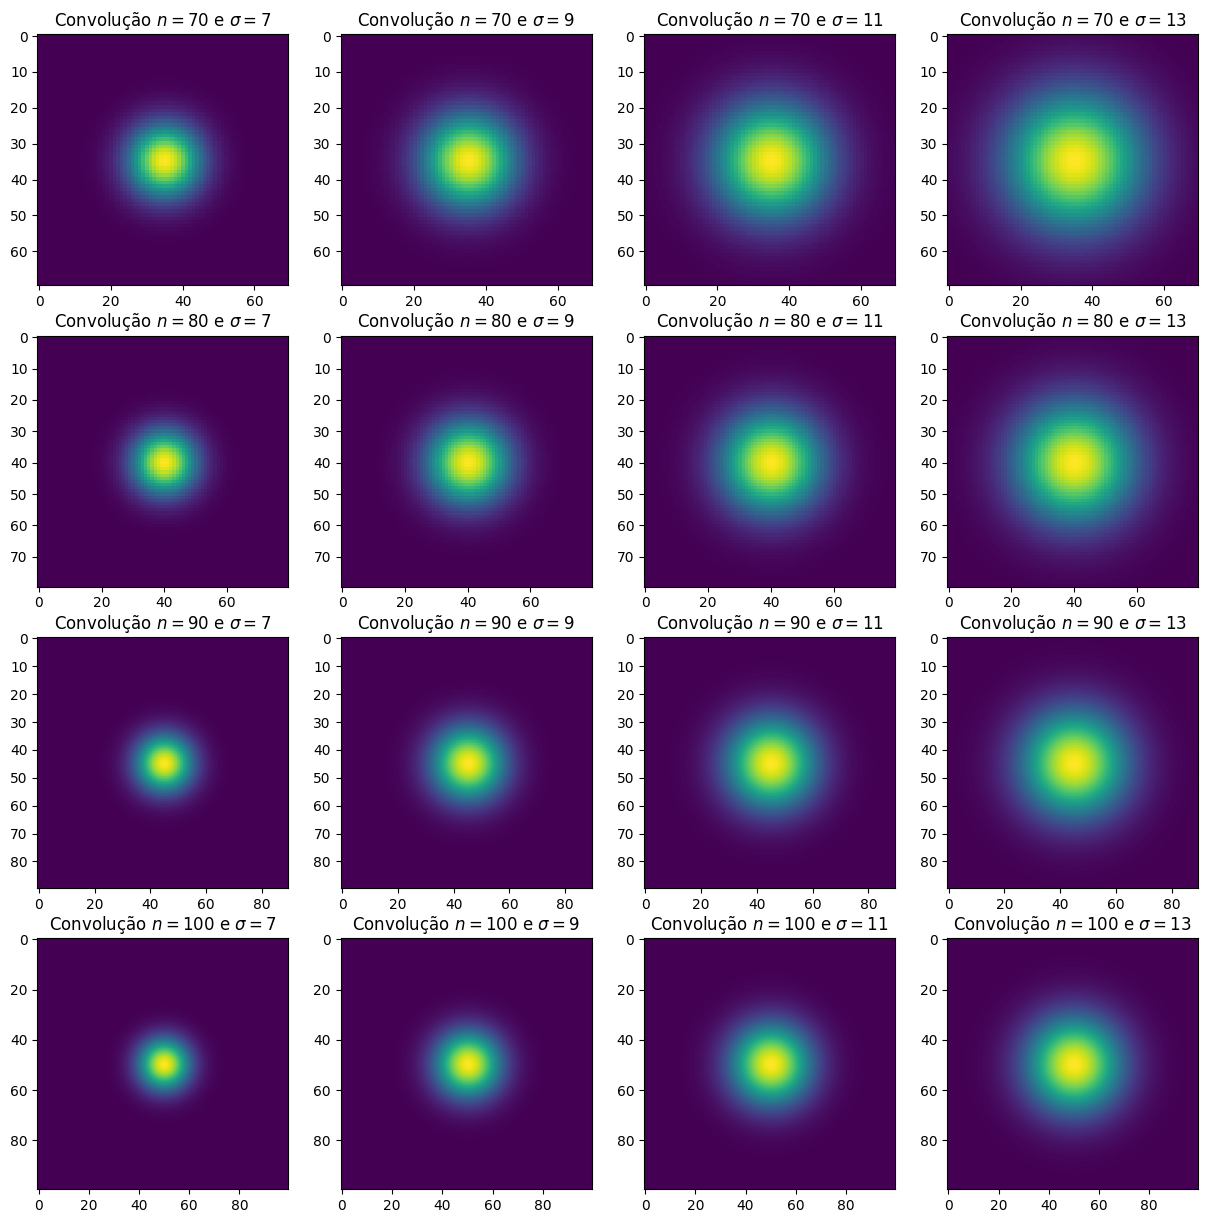

In [48]:
plot=1
fig = plt.figure(figsize=(15,15))
for i in range (7,11):
    for sigma in range(7,14,2):
        ax = fig.add_subplot(4, 4, plot)
        plot += 1
        kernel = gaussian_kernel(kernel_size=i*10, sigma = sigma) 
        ax.title.set_text(f'Convolução $n={i*10}$ e $\sigma={sigma}$')
        ax.imshow(kernel)

Diferentemente das distribuições de média no filtro passa baixa, as distribuições gaussianas tem uma maior influência do pixel central e menor contribuição dos pixeis mais próximos as extremidades

Os valores em roxo tendem a ter contribuição 0 no cálculo da convolução, então, uma vez que o Kernel tenha um tamanho suficiente, para um $\sigma = 7$ por exemplo, temos uma contribuição parecida da vizinhança. Portanto, independente do número de vizinhos total utilizados: O que aumenta do n=70 e o n=100 para o mesmo $\sigma$ é o tanto de vizinhos com contribuição próxima de 0. Isso acontece pois nosso Kernel tem tamanho suficiente para armazenar toda a distribuição gaussiana dentro dele.

Agora, vamos trabalha com filtros passa alta. Esses filtros são interessantes para detecção de bordas e vamos definir duas regras para criação desse filtro:

- Caso o tamanho do kernel seja ímpar, o único elemento central será responsável pela detecção do pixel
- Caso seja par, o quadrado 2x2 central da matriz Kernel detectará o pixel

In [49]:
def kernel_high_pass(n):
    kernel=[]
    n=n #DEFININDO A DIMENSÃO DO KERNEL
    for i in range(n):
        row=[] 
        for j in range(n): 
            row.append(-1) 
        kernel.append(row) 
    kernel = np.array(kernel)

    if n%2 == 0:
        i = 0
        for row in kernel:
            if int(n/2)-1 <= i and i <= int(n/2):
                row[int(n/2 - 1)] =  (n**2 - 4)/4
                row[int(n/2)] =  (n**2 - 4)/4
            i+=1
    else:
        kernel[int(n/2)][int(n/2)] =  n**2 - 1
    kernel = cv.flip(kernel, 0) 
    return kernel

In [50]:
print("n=3\n",kernel_high_pass(n=3))
print("n=4\n",kernel_high_pass(n=4))

n=3
 [[-1 -1 -1]
 [-1  8 -1]
 [-1 -1 -1]]
n=4
 [[-1 -1 -1 -1]
 [-1  3  3 -1]
 [-1  3  3 -1]
 [-1 -1 -1 -1]]


Convoluindo os dois filtros na imagem que estamos usando:

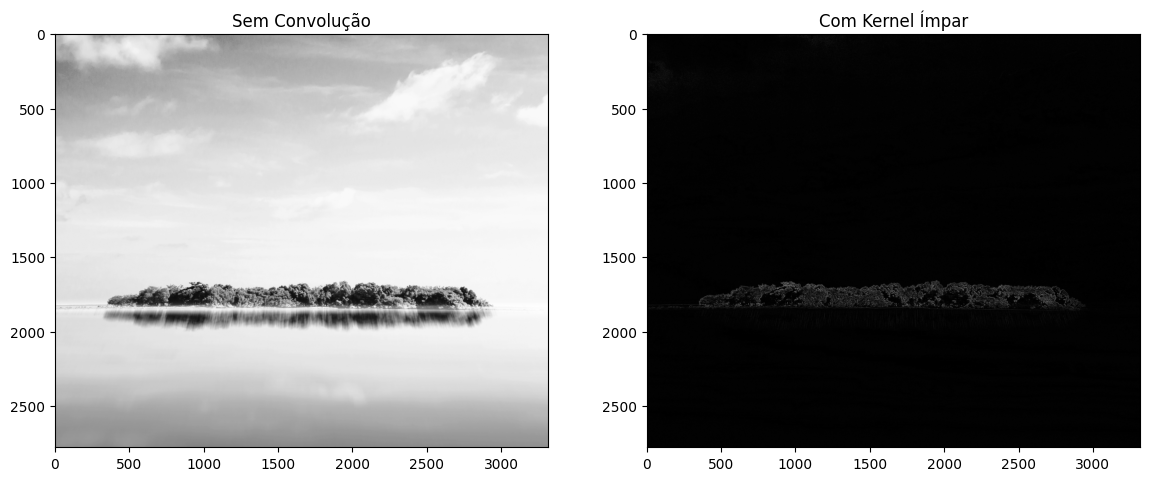

In [51]:
img = cv.imread('img_tarefa1.jpg') 
kernel_impar = kernel_high_pass(n=3)
flt_img5 = cv.filter2D(img,-1,kernel_impar) 

fig = plt.figure(figsize=(14, 14))

ax1 = fig.add_subplot(2,2,1)
ax1.title.set_text('Sem Convolução')
ax1.imshow(img)

ax2 = fig.add_subplot(2,2,2)
ax2.title.set_text('Com Kernel Ímpar')
ax2.imshow(flt_img5)

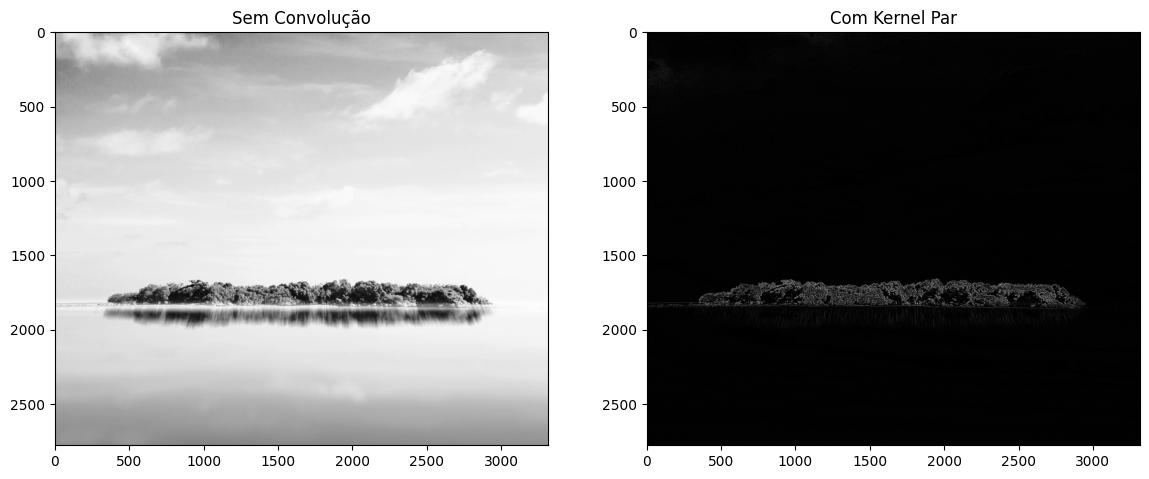

In [52]:
img = cv.imread('img_tarefa1.jpg') 
kernel_par = kernel_high_pass(n=4)
flt_img6 = cv.filter2D(img,-1,kernel_par) 

fig = plt.figure(figsize=(14, 14))

ax1 = fig.add_subplot(2,2,1)
ax1.title.set_text('Sem Convolução')
ax1.imshow(img)

ax2 = fig.add_subplot(2,2,2)
ax2.title.set_text('Com Kernel Par')
ax2.imshow(flt_img6)

Agora, vamos gerar uma matriz identidade de tamanho n para, ao somarmos com o valor do kernel, obtermos de volta nossa imagem original, porém, com as bordas destacadas

In [53]:
def identidade(n):
    kernel=[]
    n=n #DEFININDO A DIMENSÃO DO KERNEL
    for i in range(n):
        row=[] 
        for j in range(n): 
            row.append(0) 
        kernel.append(row) 
    kernel = np.array(kernel)

    if n%2 == 0:
        i = 0
        for row in kernel:
            if int(n/2)-1 <= i and i <= int(n/2):
                row[int(n/2 - 1)] = 1
                row[int(n/2)] =  1
            i+=1
    else:
        kernel[int(n/2)][int(n/2)] = 1
    kernel = cv.flip(kernel, 0) 
    if n%2 == 0:
        kernel = kernel/4
    return kernel

identidade_4 = identidade(n=4)
print(identidade_4)

[[0.   0.   0.   0.  ]
 [0.   0.25 0.25 0.  ]
 [0.   0.25 0.25 0.  ]
 [0.   0.   0.   0.  ]]


Agora, podemos somar essa matriz identidade com o kernel gerado para o filtro passa alta para um mesmo valor de $n$

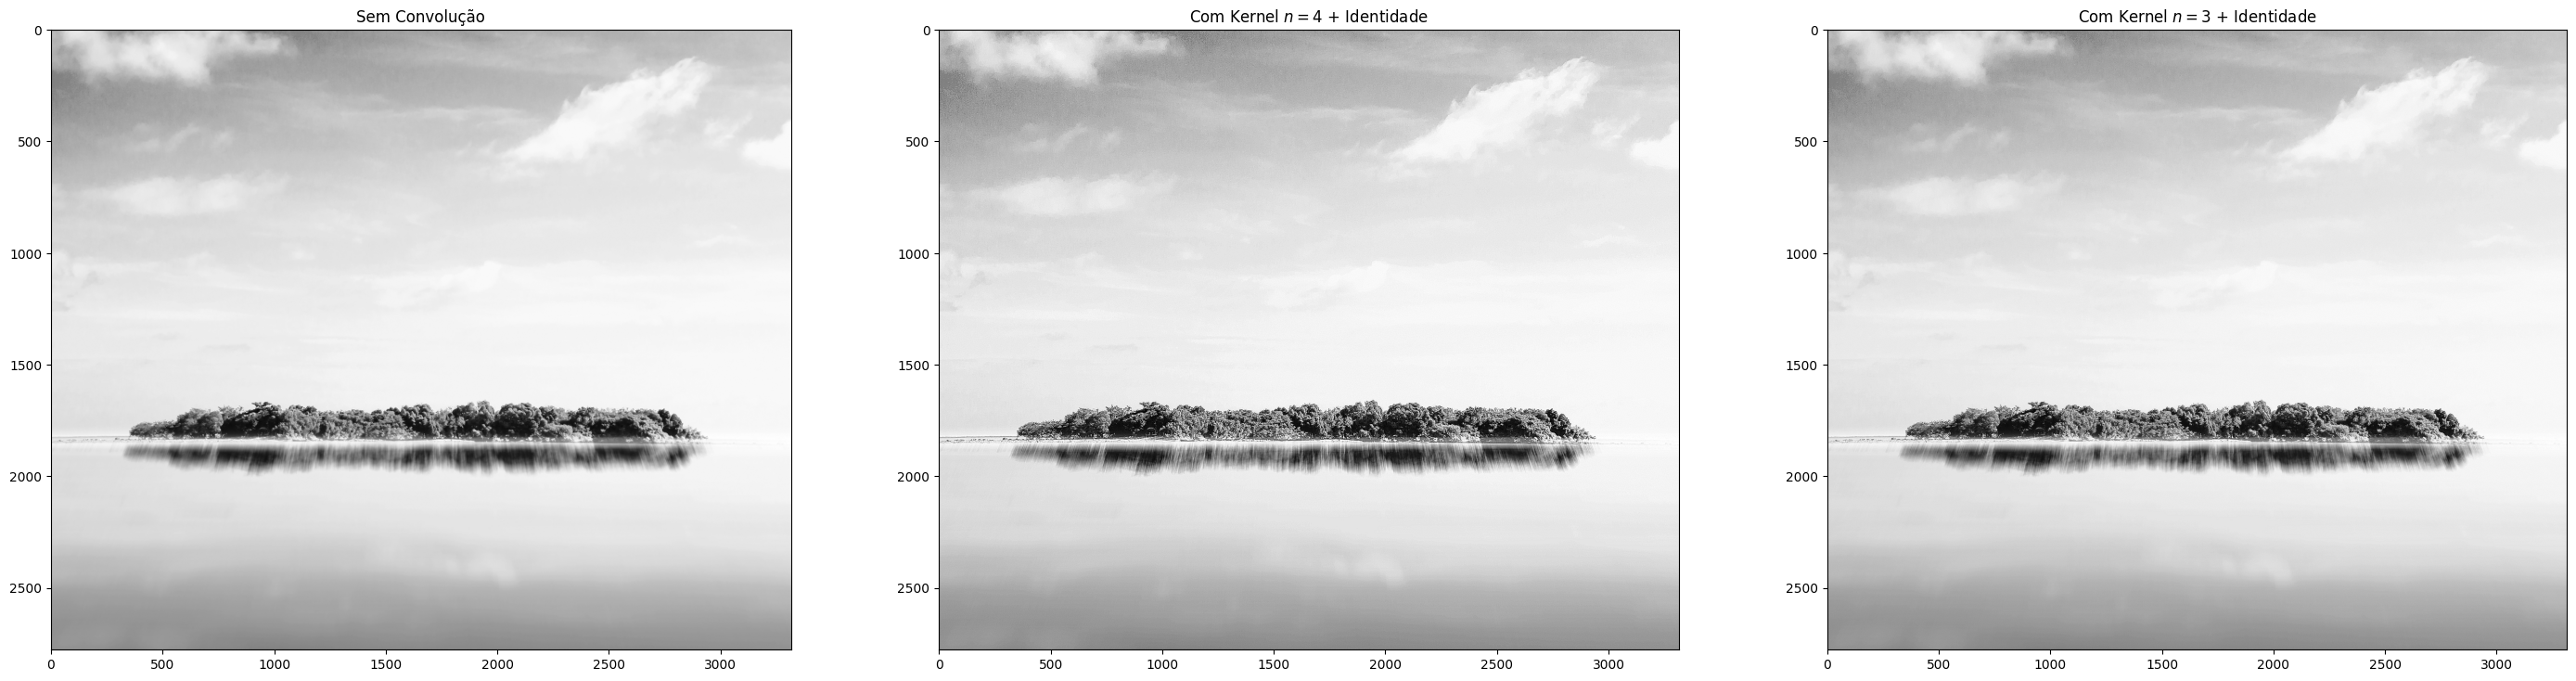

In [54]:
kernel_final_par = kernel_par + identidade_4
kernel_final_impar = kernel_impar + identidade(n=3)

img = cv.imread('img_tarefa1.jpg') 
flt_img7 = cv.filter2D(img,-1,kernel_final_par) 
flt_img8 = cv.filter2D(img,-1,kernel_final_impar) 

fig = plt.figure(figsize=(35, 35))

ax1 = fig.add_subplot(2,3,1)
ax1.title.set_text('Sem Convolução')
ax1.imshow(img)

ax2 = fig.add_subplot(2,3,2)
ax2.title.set_text('Com Kernel $n=4$ + Identidade')
ax2.imshow(flt_img7)

ax3 = fig.add_subplot(2,3,3)
ax3.title.set_text('Com Kernel $n=3$ + Identidade')
ax3.imshow(flt_img8)


Assim, conseguimos a mesma imagem, porém, com as bordas mais bem definidas seguindo o kernel $n=3$ e $n=4$. Particularmente, o resultado do Kernel n=4 me parece mais bem definido, acredito que pela imagem escolhida ter muita variação de frequência em pixeis próximos e, como o kernel $n=4$ aborda mais píxeis ao computar a borda, acredito que funcionou melhor na imagem em específico